# Processing of DIC data using numpy/scipy

Enable plotting using the `widget` front-end of matplotlib and import numpy and matplotlib packages as `np` and `plt`.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

Import the regular grid interpolator

In [2]:
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay

In [3]:
import os.path as op
import os

## Read the history of displacements and strains

In [7]:
base_dir = op.expanduser('~')
base_dir = op.join('C:\\', '97_jupyter', 'dic_jupyter_tutorial')
data_dir_name = 'S16_01_epsX'
time_F_dic_file_name = 'S16-1_Kraft.csv'
data_path = op.join(base_dir, 'S16')
csv_data_dir = op.join(data_path, data_dir_name)
time_F_dic_file = op.join(data_path, time_F_dic_file_name)
npz_file = op.join(data_path, 'S16.npz')

In [8]:
# base_dir = op.join('/fileserver', '97_jupyter', 'dic_jupyter_tutorial')
# data_dir_name = 'S16_01_epsX'
# time_F_dic_file_name = 'S16-1_Kraft.csv'
# data_path = op.join(base_dir, 'S16')
# csv_data_dir = op.join(data_path, data_dir_name)
# time_F_dic_file = op.join(data_path, time_F_dic_file_name)
# npz_file = op.join(data_path, 'S16.npz')
# npz_file

In [9]:
data = np.load(npz_file)

In [10]:
X_0Qa, U_TQa = data['X_0Qa'], data['U_TQa']
U_TQa.shape

(231, 10689, 3)

In [11]:
n_T = len(U_TQa)

In [12]:
X_0Qa.shape, U_TQa.shape, (X_0Qa + U_TQa[1]).shape

((10689, 3), (231, 10689, 3), (10689, 3))

### Displacement at nodes

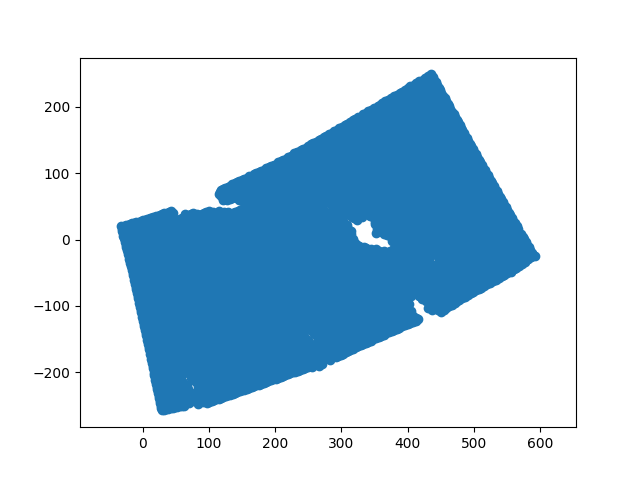

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
T = 100
U_factor = 100
X_scaled_Qa = X_0Qa + U_factor * U_TQa[T]
args = (X_scaled_Qa[:, 0], X_scaled_Qa[:, 1])
ax.scatter(*args);
ax.axis('equal');
# ax.set_xlim(200,205)
# ax.set_ylim(-100,-105)

In [14]:
points = X_0Qa[:, :-1]
delauney = Delaunay(points)

## Displacement interpolation grid to calculate strains

The monitored area is not rectangular and not aligned with the camera configuration. Therefore, we introduce padding which cu

In [15]:
pad_b, pad_t, pad_r, pad_l = 40, 40, 40, 40

In [16]:
X_outer_frame = np.min(X_0Qa, axis=0), np.max(X_0Qa, axis=0)
X_outer_frame

(array([-4.42888316e-01, -2.78027757e+02, -1.79284630e-02]),
 array([497.05001733,   8.53331718,   1.79656234]))

In [17]:
n_a = 2

### Interpolation grid

In [18]:
X_min_a, X_max_a = X_outer_frame
L_a = X_max_a - X_min_a # frame dimensions
d = 4 # 4 mm distances
n_a = 2 # number of spatial dimensions
n_I, n_J = np.array( L_a[:-1] / d, dtype=np.int_ )
d_X_a = [L_a[0]/n_I, L_a[1]/n_J]
n_I, n_J

(124, 71)

In [19]:
min_x, min_y, _ = X_min_a
max_x, max_y, _ = X_max_a
X_aIJ = np.mgrid[
        min_x + pad_l:max_x - pad_r:complex(n_I),
        min_y + pad_b:max_y - pad_t:complex(n_J)]
x_IJ, y_IJ = X_aIJ
X0_IJa = np.einsum('aIJ->IJa', np.array([x_IJ, y_IJ]))

In [20]:
x0_IJ, y0_IJ = np.einsum('IJa->aIJ', X0_IJa)
U_IJa_list = []
for T in range(n_T):
    values = U_TQa[T, :, :]
    get_U = LinearNDInterpolator(delauney, values)
    U_IJa = get_U(x0_IJ, y0_IJ)
    U_IJa_list.append(U_IJa)
U_TIJa = np.array(U_IJa_list)[...,:-1]

## Strain field history

The following five cells deliver the derivatives in the quadrature points

In [21]:
I,J,a = [np.arange(n) for n in (n_I,n_J,n_a)]
G_aIJ = (np.einsum('a, I->aI', (1-a), I)[:,:, None] + 
         np.einsum('a, J->aJ', a, J)[:,None, :])

In [22]:
n_i, n_j = 2, 2
g_aij = G_aIJ[:,:n_i,:n_j]
n_E, n_F = n_I-1, n_J-1
G_aEF = G_aIJ[:,:-1,:-1]
H_aEiFj = G_aEF[:,:,None,:,None] + g_aij[:,None,:,None,:]
X_EiFja = X0_IJa[(*H_aEiFj,)]
U_TEiFja = U_TIJa[(slice(None), *H_aEiFj)]

In [23]:
delta_rs = np.eye(2, dtype=np.int_)
xi_rij = (H_aEiFj[:,0,:,0,:] * 2) - 1
n_m, n_n = n_i, n_j
eta_rmn = 3**(-1/2) * xi_rij
N_ijmn = (1 + 
  np.einsum('rmn,rij->ijmn', eta_rmn, xi_rij) +
  np.einsum('rs,smn,sij,rmn,rij->ijmn', (1-delta_rs), eta_rmn, xi_rij, eta_rmn, xi_rij) / 2
)/4

In [24]:
dN_sijmn = (
    xi_rij[:,:,:,None,None] + 
    np.einsum('rs,sij,rmn,rij->sijmn', (1 - delta_rs), xi_rij, eta_rmn, xi_rij)
) / 4
J_EmFnas = np.einsum(
 'sijmn,EiFja->EmFnas',
 dN_sijmn, X_EiFja
)
inv_J_EmFnsa = np.linalg.inv(J_EmFnas)

In [25]:
delta_ab = np.eye(2)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta_ab, delta_ab) +
    np.einsum('ad,bc->abcd', delta_ab, delta_ab)
)
B_EiFjmnabc = np.einsum(
    'abcd,sijmn,EmFnsd->EiFjmnabc',
    Diff1_abcd, dN_sijmn, inv_J_EmFnsa
)

In [26]:
eps_TEmFnab = np.einsum(
    'EiFjmnabc,TEiFjc->TEmFnab',
    B_EiFjmnabc, U_TEiFja
)
eps_TEmFnab.shape

(231, 123, 2, 70, 2, 2, 2)

## Export the data to paraview

In [27]:
X_aEmFn = np.einsum('ijmn,EiFja->aEmFn', N_ijmn, X_EiFja)
X_aKL = X_aEmFn.reshape(-1,(n_I-1)*2, (n_J-1)*2)
X_KLa = np.einsum('aKL->KLa', X_aKL)

In [28]:
eps_TKLab = eps_TEmFnab.reshape(-1, n_E*n_m, n_F*n_n, 2, 2)
eps_TKxLab = eps_TEmFnab.reshape(-1, n_E*n_m*n_F*n_n, 2, 2)
eigenvalues = np.zeros((eps_TKLab.shape[0], eps_TKLab.shape[1]*eps_TKLab.shape[2], 2))

# for t in range(eps_TKLab.shape[0]):
#     # Iterate over each point
#     for i in range(eps_TKLab.shape[1]*eps_TKLab.shape[2]):
#         # Get the strain tensor at time t for point i
#         strain_tensor_point = eps_TKxLab[t, i]
#         # Compute the eigenvalues
#         eigenvalues[t, i] = np.linalg.eigvals(strain_tensor_point)

In [29]:
eigenvalues.shape

(231, 34440, 2)

In [30]:
from pyevtk.hl import gridToVTK, unstructuredGridToVTK, pointsToVTK

# assuming you have eps_TKLab, X_KLa variables defined
# get the time steps and the grid size
T, nx, ny, a, b = eps_TKLab.shape

eps3d_TKab = np.zeros((T, nx*ny, 3, 3), dtype=np.float_)
# get the grid coordinates
x = np.ascontiguousarray(X_KLa[:, :, 0].flatten())
y = np.ascontiguousarray(X_KLa[:, :, 1].flatten())
z = np.zeros_like(x)
connectivity = np.empty(0, dtype=np.int32)

# Calculate offsets array (only one element for a point cloud)
offsets = np.array([0], dtype=np.int32)

# Generate cell types array (empty for a point cloud)
cell_types = np.empty(0, dtype=np.uint8)

# Total number of cells (0 for a point cloud)
num_cells = 0
# x = np.linspace(0, 1, nx)
# y = np.linspace(0, 1, ny)
# z = np.zeros(1)


In [31]:
eps3d_TKab.shape

(231, 34440, 3, 3)

In [32]:
# for each time step save a vtr file
for t in range(T):
    
    eps3d_TKab[t, :, :2, :2] = eps_TKxLab[t, ...]
    tensor_field = eps3d_TKab.reshape(-1, 3, 3)
    # get the tensor field at the current time step

    # create the path for the VTR file
    # FILE_PATH = f"./temp/tensor_field_{t}"
    FILE_PATH = f"C:/97_jupyter/dic_jupyter_tutorial/S16/paraview/eps_xx_{t}"

    # export to VTR

    pointsToVTK(FILE_PATH, x, y, z,
              data = {"eps_xx" : np.ascontiguousarray(eps3d_TKab[t,:,0,0])})
    
#     FILE_PATH = f"E:/97_jupyter/VB1/paraview/eps_II_{t}"

#     pointsToVTK(FILE_PATH, x, y, z,
#               data = {"eps_II" : np.ascontiguousarray(eigenvalues[t,:,1])})
    

## Evaluation of damage

In [25]:
eps_TEmFna, _ = np.linalg.eig(eps_TEmFnab)

In [26]:
kappa_TEmFn = np.max(eps_TEmFna, axis=-1)
kappa_TKL = kappa_TEmFn.reshape(-1, n_E*n_m, n_F*n_n)
kappa_TKL[np.where(kappa_TKL<0)] = 0

In [27]:
eps_0=0.002
#eps_f=0.0028
eps_f=0.003

In [28]:
I = np.where(kappa_TEmFn>=eps_0)
omega_TEmFn = np.zeros_like(kappa_TEmFn)
omega_TEmFn[I] = 1.0-(eps_0/kappa_TEmFn[I]*np.exp(
    -(kappa_TEmFn[I]-eps_0)/(eps_f-eps_0))
)

In [29]:
omega_TKL = omega_TEmFn.reshape(-1, n_E*n_m, n_F*n_n)

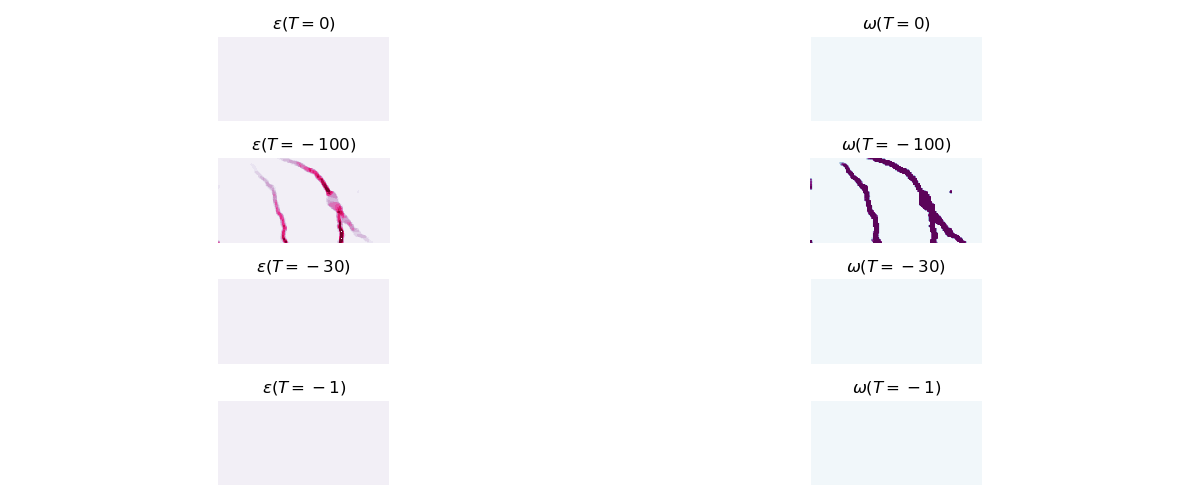

In [32]:
fig = plt.figure(figsize=(12,5), tight_layout=True)
fig.canvas.header_visible = False
T_selection = [0, -100, -30, -1]
rows = fig.subplots(len(T_selection), 2)
for (ax_eps, ax_omega), T in zip(rows, T_selection):
    ax_eps.contourf(X_aKL[0], X_aKL[1], kappa_TKL[T], cmap='PuRd', 
                    levels=np.linspace(0,0.05,15)) # , vmin=eps_0, vmax=50*eps_0,)
    ax_eps.axis('equal');
    ax_eps.axis('off');
    ax_eps.set_title(r'$\varepsilon(T={}$)'.format(T));
    ax_omega.contourf( X_aKL[0], X_aKL[1], omega_TKL[T], cmap='BuPu', levels=np.linspace(0,1,15))
#                      vmin=0, vmax=1)
    ax_omega.axis('equal');
    ax_omega.axis('off');
    ax_omega.set_title(r'$\omega(T={})$'.format(T));

In [33]:
eps_TKLa = eps_TEmFna.reshape(-1, n_E*n_m, n_F*n_n, n_a)

In [34]:
np.max(eps_TKLa)

3.53469401638905

In [35]:
eps_TKL_comp = np.copy(eps_TKLa[:, :, :, 1])
eps_TKL_comp[eps_TKL_comp>0] = 0
eps_TKL_comp[eps_TKLa[:, :, :, 0] > 0.005 ] = 0
eps_min_val = np.min(eps_TKL_comp)
eps_min_val

-0.012424284362294195

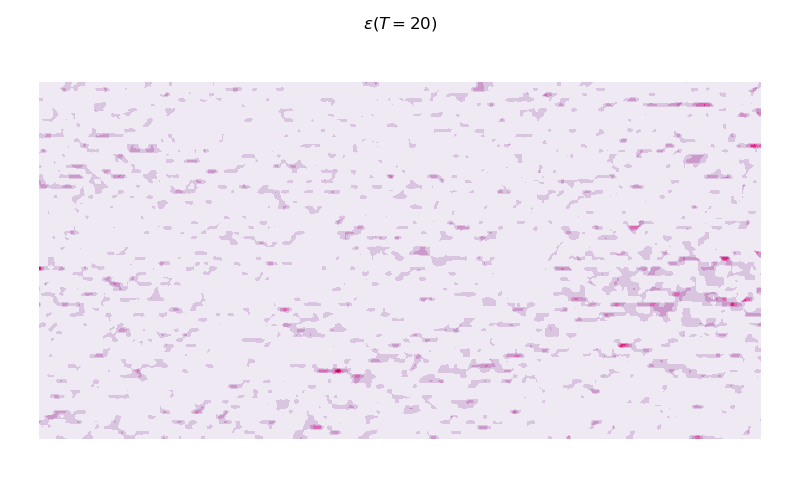

In [36]:
fig = plt.figure(figsize=(8,5), tight_layout=True)
fig.canvas.header_visible = False
T = 20
ax = fig.subplots(1,1)
ax.contourf(X_aKL[0], X_aKL[1], eps_TKL_comp[-1], cmap='PuRd_r'), 
#                    levels=np.linspace(0,1,10)) # , vmin=eps_0, vmax=50*eps_0,)
ax.axis('equal');
ax.axis('off');
ax.set_title(r'$\varepsilon(T={})$'.format(T));

In [ ]:
eps_TKLab = eps_TEmFnab.reshape(-1, n_E*n_m, n_F*n_n, n_a, n_a)
sig_TKLab = np.einsum(',...,...ab->...ab', 30000, (1 - omega_TKL), eps_TKLab)

In [ ]:
E_TKL = np.einsum('...ab,...ab->...', sig_TKLab, eps_TKLab) 

In [ ]:
np.max(E_TKL), np.min(E_TKL)

In [ ]:
fig = plt.figure(figsize=(8,5), tight_layout=True)

T = 20
ax = fig.subplots(1,1)
ax.contourf(X_aKL[0], X_aKL[1], E_TKL[T], cmap='PuRd'), 
#                    levels=np.linspace(0,1,10)) # , vmin=eps_0, vmax=50*eps_0,)
ax.axis('equal');
ax.axis('off');
ax.set_title(r'$E(T={})$'.format(T));